# Sentimental Analysis

In [2]:
import sagemaker
sess = sagemaker.Session()
bucket = sess.default_bucket()
# !aws s3 ls s3://{bucket}/project/submissions/ --recursive

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [3]:
# Setup - Run only once per Kernel App
%conda install https://anaconda.org/conda-forge/openjdk/11.0.1/download/linux-64/openjdk-11.0.1-hacce0ff_1021.tar.bz2

# install PySpark
%pip install pyspark==3.4.0

# install seaborn
%pip install seaborn

# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")




## Package Plan ##

  environment location: /opt/conda



Preparing transaction: done
Verifying transaction: done
Executing transaction: done

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [4]:
!pip install spark-nlp==5.5.0

In [5]:
from pyspark.sql import SparkSession
import sparknlp
from sparknlp.base import *
from pyspark.ml import Pipeline
from sparknlp.annotator import *
from sparknlp.pretrained import PretrainedPipeline

spark = SparkSession.builder \
    .appName("Spark NLP")\
    .master("local[*]")\
    .config("spark.driver.memory","32G")\
    .config("spark.driver.maxResultSize", "0") \
    .config("spark.kryoserializer.buffer.max", "2000M")\
    .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:5.1.3,org.apache.hadoop:hadoop-aws:3.2.2")\
    .config("fs.s3a.aws.credentials.provider", "com.amazonaws.auth.ContainerCredentialsProvider")\
    .getOrCreate()

print(spark.version)

:: loading settings :: url = jar:file:/opt/conda/lib/python3.11/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/sagemaker-user/.ivy2/cache
The jars for the packages stored in: /home/sagemaker-user/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-279f92ba-ffb8-44a2-a9db-e46c88cc7f68;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;5.1.3 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.828 in central
	found com.github.universal-automata#liblevenshtein;3.0.0 in central
	found com.google.protobuf#protobuf-java-util;3.0.0-beta-3 in central
	found com.google.protobuf#protobuf-java;3.0.0-beta-3 in central
	found com.google.code.gson#gson;2.3 in central
	found it.unimi.dsi#fastutil;7.0.12 in central
	found org.projectlombok#lombok;1.16.8 in central
	found com.google.cloud#google-cloud-storage;2.20.1 in central
	found com.go

3.4.0


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F

In [7]:
submissions = spark.read.parquet(f"s3a://{bucket}/project/filtered_submissions/*.parquet", header=True).cache()

24/12/07 05:48:32 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


In [8]:
submissions = submissions.repartition(64)

In [9]:
filtered_submissions = submissions \
    .withColumn('selftext', F.regexp_replace(submissions['selftext'], r'\[removed\]', '')) \
    .filter(~F.col("selftext").contains("[deleted]")) \
    .withColumn('text', F.concat(F.col('title'), F.col('selftext'))) \
    .withColumn("text", F.regexp_replace(F.col("text"), "[^a-zA-Z]", " "))
    # .withColumn('text', F.regexp_replace(F.col('text'), '[\(\)\{\},.:;\'\"\?\n\*0-9]', '')) \

## Sentiment Analysis

In [10]:
MODEL_NAME='sentimentdl_use_twitter'

documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")
    
use = UniversalSentenceEncoder.pretrained(name="tfhub_use", lang="en")\
     .setInputCols(["document"])\
     .setOutputCol("sentence_embeddings")

sentimentdl = SentimentDLModel.pretrained(name=MODEL_NAME, lang="en")\
    .setInputCols(["sentence_embeddings"])\
    .setOutputCol("sentiment")

nlpPipeline = Pipeline(
      stages = [
          documentAssembler,
          use,
          sentimentdl
      ])

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[ / ]tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
Download done! Loading the resource.
[ / ]

2024-12-07 05:48:55.676529: I external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[ / ]

[OK!]
sentimentdl_use_twitter download started this may take some time.
Approximate size to download 11.4 MB
[ / ]sentimentdl_use_twitter download started this may take some time.
Approximate size to download 11.4 MB
Download done! Loading the resource.
[OK!]


In [11]:
pipelineModel = nlpPipeline.fit(filtered_submissions)
results = pipelineModel.transform(filtered_submissions)

In [12]:
submissions_sentiment = results.withColumn("sentiment", F.col("sentiment").getField("result").getItem(0)) \
    .select("subreddit","author","text","num_comments","score","date","sentiment","is_biden", "is_trump","id")

In [13]:
# output_path = f"s3a://{bucket}/project/submissions_sentiments"
# submissions_sentiment.write.mode("overwrite").parquet(output_path)
pd_sentiments = submissions_sentiment.toPandas()

### Sentiments over time with Presidential Job Approval Rate

In [14]:
satisfaction_rate = pd.read_csv("../../data/csv/data-8Z3B3.csv")
approval_rate = pd.read_csv("../../data/csv/Biden_Public_Approval.csv")

In [15]:
satisfaction_rate.columns = ["date", "satisfaction"]
satisfaction_rate["date"] = pd.to_datetime(satisfaction_rate['date'], format='%b %d %Y', errors='coerce')
start_date = "2023-06-01"
end_date = "2024-07-31"
satisfaction_rate = satisfaction_rate[(satisfaction_rate["date"] >= start_date) & (satisfaction_rate["date"] <= end_date)]

approval_rate['date'] = pd.to_datetime(approval_rate['Start Date'], format='%m/%d/%y')

In [16]:
pd_sentiments['timestamp'] = pd.to_datetime(pd_sentiments['date'])

# Extract the year and month from the timestamp
pd_sentiments['year_month'] = pd_sentiments['timestamp'].dt.to_period('M')

# Group by subreddit and year_month, then count sentiments
agg_sent = pd_sentiments.groupby(['subreddit', 'year_month', "is_biden","is_trump",'sentiment']).size().unstack(fill_value=0)
agg_sent = agg_sent.reset_index()

#### Trump-related Sentiments Across subreddits

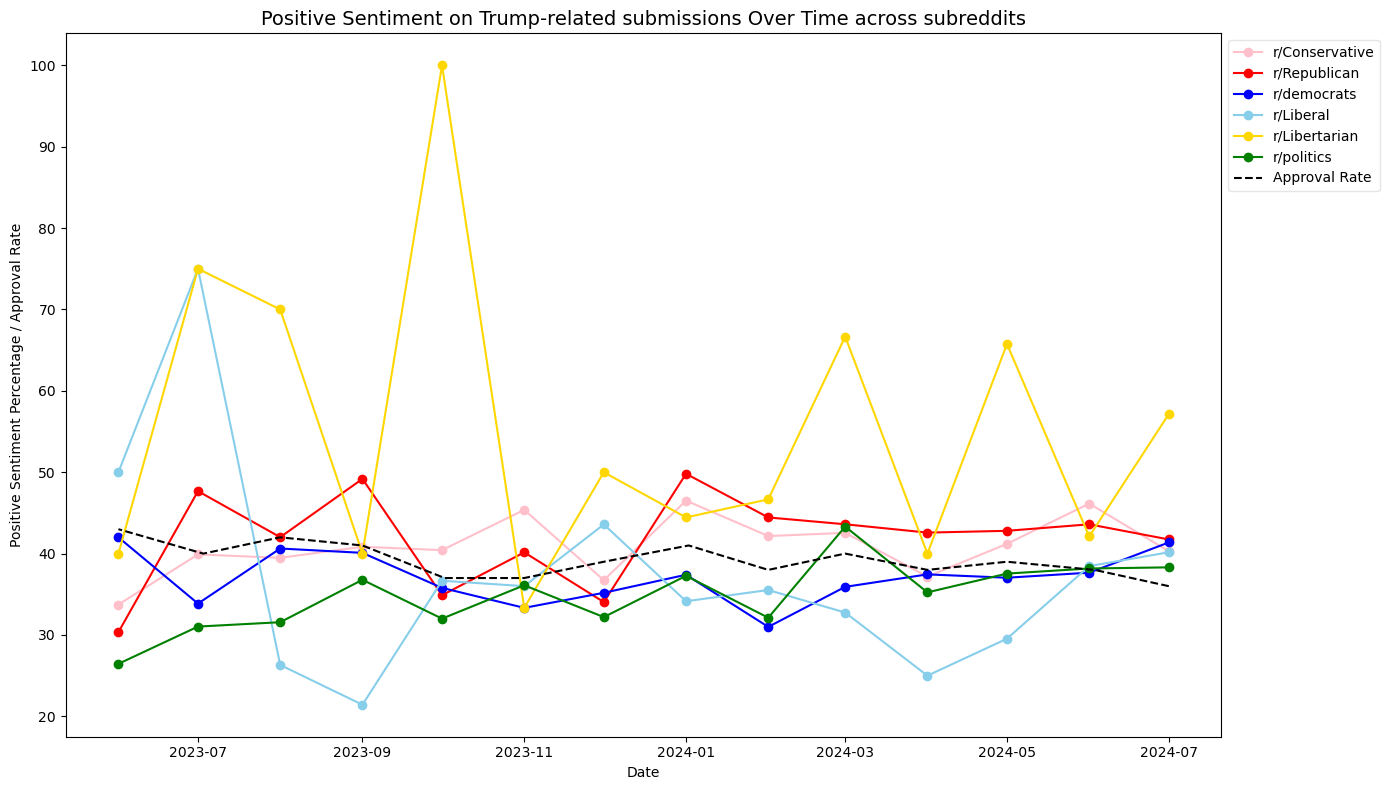

In [17]:
# Initialize the plot
plt.figure(figsize=(14, 8))

# Define the subreddits and their associated colors
subreddits = ["Conservative", "Republican", "democrats", "Liberal", "Libertarian", "politics"]
colors = {
    "Conservative": "pink",
    "Republican": "red",
    "democrats": "blue",
    "Liberal": "skyblue",
    "Libertarian": "gold",
    "politics": "green"
}

# Loop over each subreddit
for subreddit in subreddits:
    # Filter the data for the current subreddit and create a copy
    subreddit_data = agg_sent[(agg_sent["subreddit"] == subreddit) & (agg_sent["is_biden"] == 0) & (agg_sent["is_trump"] == 1)].copy()
    
    # Calculate the positive percentage
    subreddit_data.loc[:, "positive_perc"] = (
        subreddit_data["positive"] / 
        (subreddit_data["positive"] + subreddit_data["neutral"] + subreddit_data["negative"]) * 100
    )
    
    # Convert 'year_month' to timestamp
    subreddit_data['year_month'] = subreddit_data['year_month'].dt.to_timestamp()

    # Plot the positive percentage for each subreddit with its specific color
    plt.plot(
        subreddit_data['year_month'], 
        subreddit_data['positive_perc'], 
        marker='o', 
        color=colors[subreddit], 
        label=f'r/{subreddit}'
    )

# Plot the satisfaction rate on the same plot
# plt.plot(satisfaction_rate['date'], satisfaction_rate['satisfaction'], color='green', linestyle='--', label='Satisfaction Rate')
plt.plot(approval_rate['date'], approval_rate['Approving'], color='black', linestyle='--', label='Approval Rate')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Positive Sentiment Percentage / Approval Rate')
plt.title('Positive Sentiment on Trump-related submissions Over Time across subreddits', fontsize = 14)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fancybox=True, framealpha=0.5)
plt.tight_layout()
plt.savefig("../../website-source/plots/trump_positive_sentiments_overtime.png", format="png", dpi=300, bbox_inches="tight", transparent=True)
plt.show()

#### Biden-related Sentiments Across subreddits

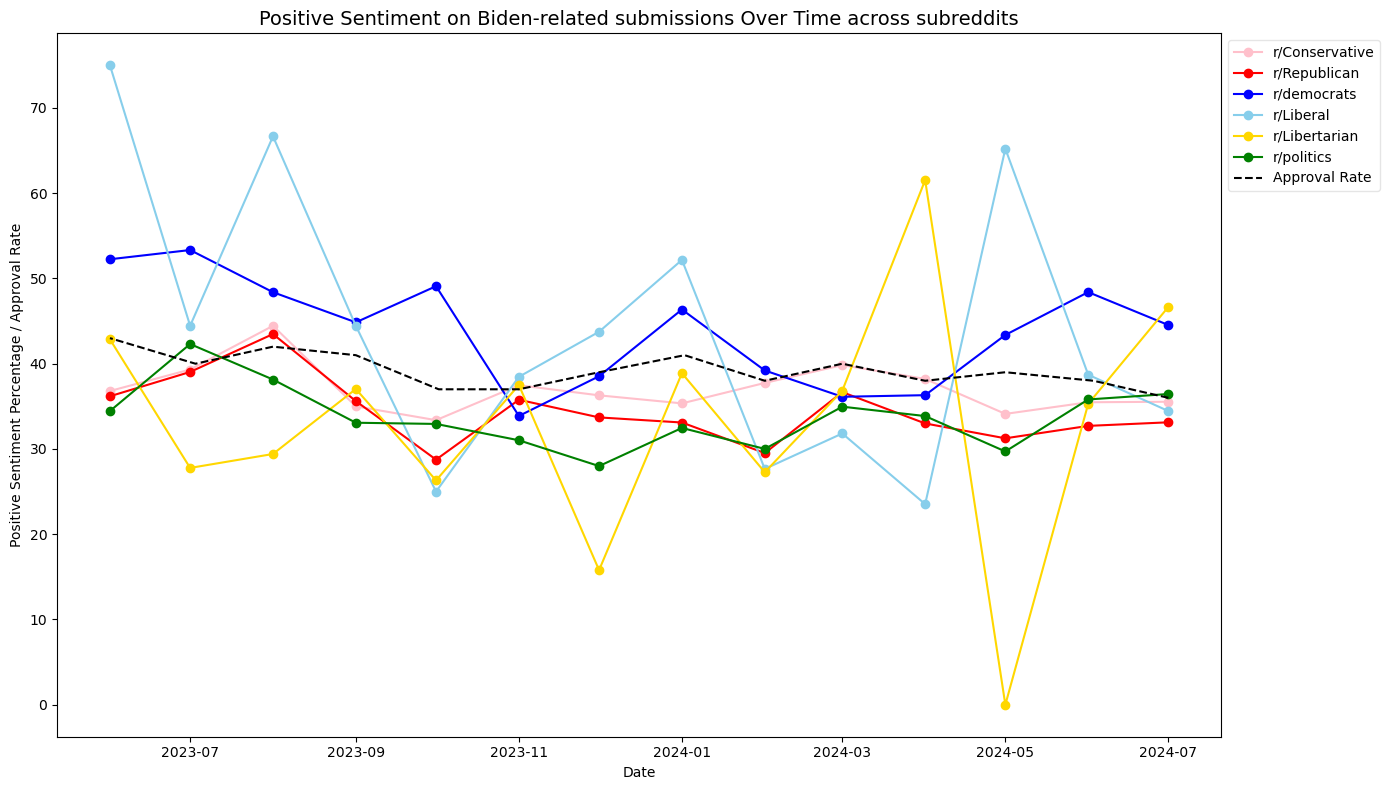

In [18]:
# Initialize the plot
plt.figure(figsize=(14, 8))

# Define the subreddits and their associated colors
subreddits = ["Conservative", "Republican", "democrats", "Liberal", "Libertarian", "politics"]
colors = {
    "Conservative": "pink",
    "Republican": "red",
    "democrats": "blue",
    "Liberal": "skyblue",
    "Libertarian": "gold",
    "politics": "green"
}

# Loop over each subreddit
for subreddit in subreddits:
    # Filter the data for the current subreddit and create a copy
    subreddit_data = agg_sent[(agg_sent["subreddit"] == subreddit) & (agg_sent["is_biden"] == 1) & (agg_sent["is_trump"] == 0)].copy()
    
    # Calculate the positive percentage
    subreddit_data.loc[:, "positive_perc"] = (
        subreddit_data["positive"] / 
        (subreddit_data["positive"] + subreddit_data["neutral"] + subreddit_data["negative"]) * 100
    )
    
    # Convert 'year_month' to timestamp
    subreddit_data['year_month'] = subreddit_data['year_month'].dt.to_timestamp()

    # Plot the positive percentage for each subreddit with its specific color
    plt.plot(
        subreddit_data['year_month'], 
        subreddit_data['positive_perc'], 
        marker='o', 
        color=colors[subreddit], 
        label=f'r/{subreddit}'
    )

# Plot the satisfaction rate on the same plot
# plt.plot(satisfaction_rate['date'], satisfaction_rate['satisfaction'], color='green', linestyle='--', label='Satisfaction Rate')
plt.plot(approval_rate['date'], approval_rate['Approving'], color='black', linestyle='--', label='Approval Rate')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Positive Sentiment Percentage / Approval Rate')
plt.title('Positive Sentiment on Biden-related submissions Over Time across subreddits', fontsize = 14)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fancybox=True, framealpha=0.5)
plt.tight_layout()
plt.savefig("../../website-source/plots/biden_positive_sentiments_overtime.png", format="png", dpi=300, bbox_inches="tight", transparent=True)
plt.show()

#### Overall Sentiments Across subreddits

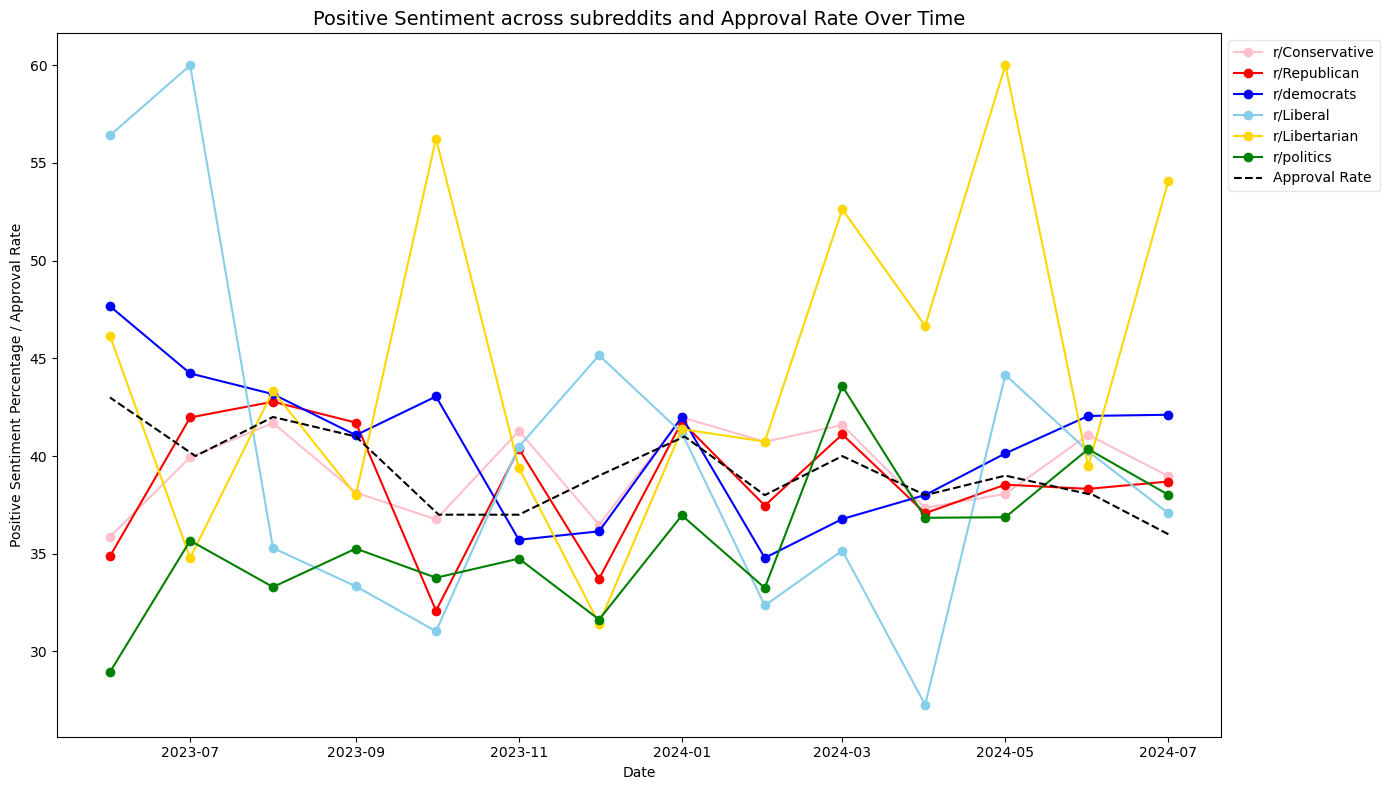

In [19]:
agg_sent = pd_sentiments.groupby(['subreddit', 'year_month','sentiment']).size().unstack(fill_value=0)
agg_sent = agg_sent.reset_index()

# Initialize the plot
plt.figure(figsize=(14, 8))

# Define the subreddits and their associated colors
subreddits = ["Conservative", "Republican", "democrats", "Liberal", "Libertarian", "politics"]
colors = {
    "Conservative": "pink",
    "Republican": "red",
    "democrats": "blue",
    "Liberal": "skyblue",
    "Libertarian": "gold",
    "politics": "green"
}

# Loop over each subreddit
for subreddit in subreddits:
    # Filter the data for the current subreddit and create a copy
    subreddit_data = agg_sent[(agg_sent["subreddit"] == subreddit)].copy()
    
    # Calculate the positive percentage
    subreddit_data.loc[:, "positive_perc"] = (
        subreddit_data["positive"] / 
        (subreddit_data["positive"] + subreddit_data["neutral"] + subreddit_data["negative"]) * 100
    )
    
    # Convert 'year_month' to timestamp
    subreddit_data['year_month'] = subreddit_data['year_month'].dt.to_timestamp()

    # Plot the positive percentage for each subreddit with its specific color
    plt.plot(
        subreddit_data['year_month'], 
        subreddit_data['positive_perc'], 
        marker='o', 
        color=colors[subreddit], 
        label=f'r/{subreddit}'
    )

# Plot the satisfaction rate on the same plot
# plt.plot(satisfaction_rate['date'], satisfaction_rate['satisfaction'], color='green', linestyle='--', label='Satisfaction Rate')
plt.plot(approval_rate['date'], approval_rate['Approving'], color='black', linestyle='--', label='Approval Rate')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Positive Sentiment Percentage / Approval Rate')
plt.title('Positive Sentiment across subreddits and Approval Rate Over Time', fontsize = 14)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fancybox=True, framealpha=0.5)
plt.tight_layout()
plt.savefig("../../website-source/plots/all_positive_sentiments_overtime.png", format="png", dpi=300, bbox_inches="tight", transparent=True)
plt.show()

### Average Number of comments on Trump related submissions by sentiment for each subreddit

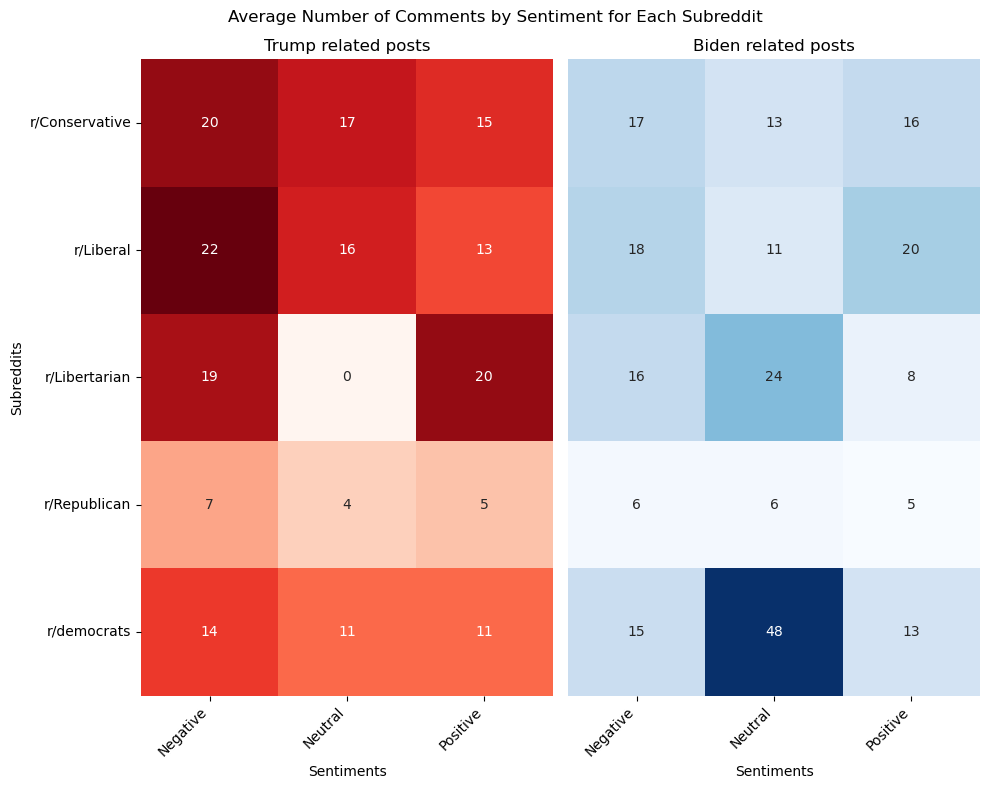

In [20]:
# Data preparation
subreddits = ["Conservative", "Republican", "democrats", "Liberal", "Libertarian"]
sub_sentiments = pd_sentiments[pd_sentiments["subreddit"].isin(subreddits)]
t_sentiments = sub_sentiments[(sub_sentiments['is_trump'] == 1) & (sub_sentiments['is_biden'] == 0)]
b_sentiments = sub_sentiments[(sub_sentiments['is_biden'] == 1) & (sub_sentiments['is_trump'] == 0)]

fig, axes = plt.subplots(1, 2, figsize=(10, 8))
# Heatmap 1: Trump-related comments (average number of comments)
heatmap_data = t_sentiments.groupby(['subreddit', 'sentiment']).agg({'num_comments': 'mean'}).unstack()
heatmap_data = heatmap_data.round().astype(int)
sns.heatmap(heatmap_data, ax=axes[0], annot=True, cmap="Reds", cbar=False)
axes[0].set_aspect('auto')
axes[0].set_xticklabels(['Negative', 'Neutral', 'Positive'], rotation=45, ha='right')
axes[0].set_yticklabels(["r/Conservative", "r/Liberal", "r/Libertarian", "r/Republican", "r/democrats"], rotation=360, ha='right')
axes[0].set_xlabel("Sentiments")
axes[0].set_ylabel("Subreddits")
axes[0].set_title("Trump related posts")

# Heatmap 2: Biden-related comments (average number of comments)
heatmap_data = b_sentiments.groupby(['subreddit', 'sentiment']).agg({'num_comments': 'mean'}).unstack()
heatmap_data = heatmap_data.round().astype(int)
sns.heatmap(heatmap_data, ax=axes[1], annot=True, cmap="Blues", cbar=False)
axes[1].set_aspect('auto')
axes[1].set_xticklabels(['Negative', 'Neutral', 'Positive'], rotation=45, ha='right')
axes[1].set_xlabel("Sentiments")
axes[1].set_yticklabels([None,None,None,None,None], rotation=45, ha='right')
axes[1].set_ylabel(None)
axes[1].tick_params(left=False)
axes[1].set_title("Biden related posts")

# Adjust layout
plt.suptitle("Average Number of Comments by Sentiment for Each Subreddit")
plt.tight_layout()
plt.savefig("../../website-source/plots/avg_comments_heatmap.png", format="png", dpi=300, bbox_inches="tight", transparent=True)
plt.show()

### Average Number of comments on Trump related submissions by sentiment for each subreddit

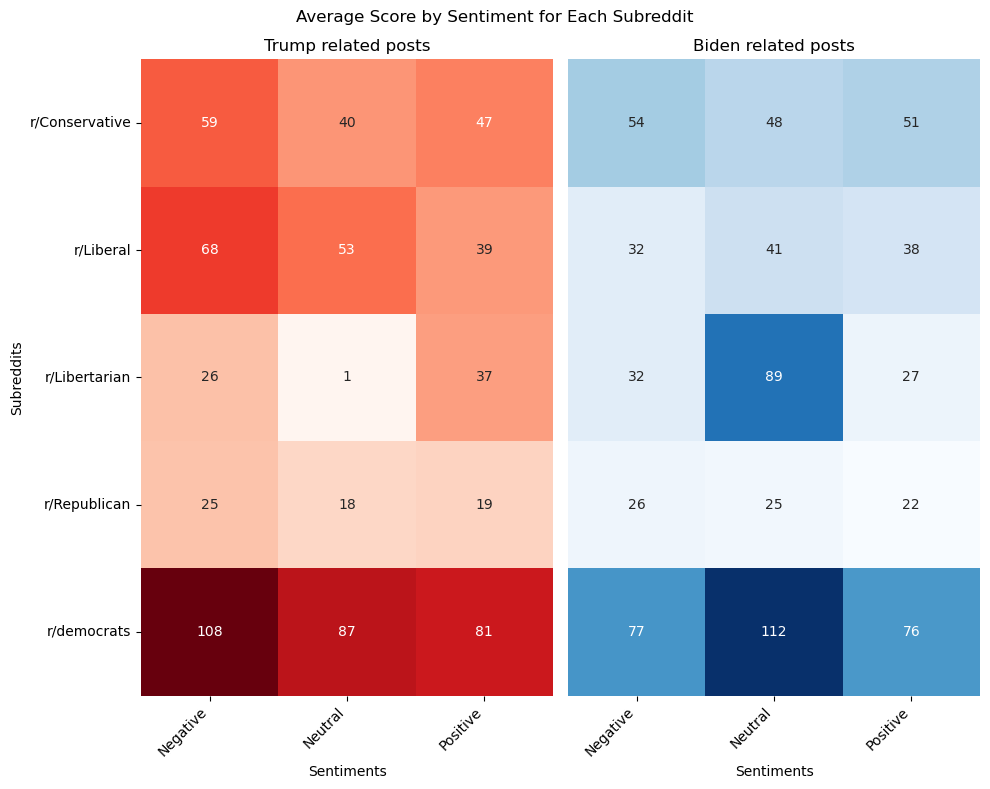

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(10, 8))

# Heatmap 3: Trump-related comments (average score)
heatmap_data = t_sentiments.groupby(['subreddit', 'sentiment']).agg({'score': 'mean'}).unstack()
heatmap_data = heatmap_data.round().astype(int)
sns.heatmap(heatmap_data, ax=axes[0], annot=True, cmap="Reds", cbar=False, fmt='d')
axes[0].set_xticklabels(['Negative', 'Neutral', 'Positive'], rotation=45, ha='right')
axes[0].set_yticklabels(["r/Conservative", "r/Liberal", "r/Libertarian", "r/Republican", "r/democrats"], rotation=360, ha='right')
axes[0].set_xlabel("Sentiments")
axes[0].set_ylabel("Subreddits")
axes[0].set_title("Trump related posts")

# Heatmap 4: Biden-related comments (average score)
heatmap_data = b_sentiments.groupby(['subreddit', 'sentiment']).agg({'score': 'mean'}).unstack()
heatmap_data = heatmap_data.round().astype(int)
sns.heatmap(heatmap_data, ax=axes[1], annot=True, cmap="Blues", cbar=False, fmt='d')
axes[1].set_xticklabels(['Negative', 'Neutral', 'Positive'], rotation=45, ha='right')
axes[1].set_xlabel("Sentiments")
axes[1].set_yticklabels([None,None,None,None,None], rotation=45, ha='right')
axes[1].set_ylabel(None)
axes[1].tick_params(left=False)
axes[1].set_title("Biden related posts")

# Adjust layout
plt.suptitle("Average Score by Sentiment for Each Subreddit")
plt.tight_layout()
plt.savefig("../../website-source/plots/avg_score_heatmap.png", format="png", dpi=300, bbox_inches="tight", transparent=True)
plt.show()

### Sentiment Distribution across subreddits

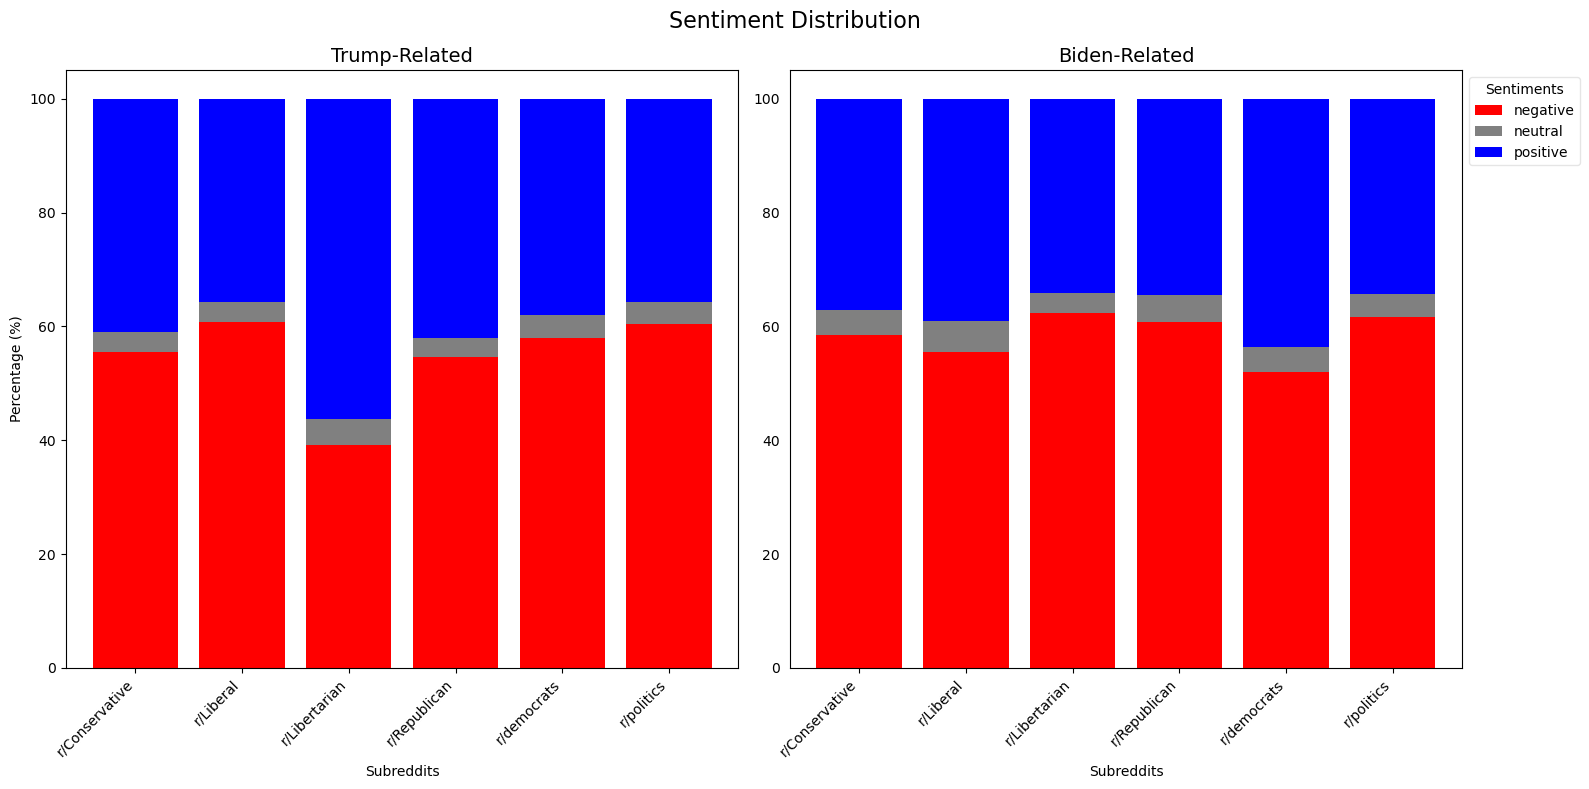

In [22]:
# Data Preparation
subreddits = ["Conservative", "Republican", "democrats", "Liberal", "Libertarian", "politics"]
sub_sentiments = pd_sentiments[pd_sentiments["subreddit"].isin(subreddits)]
t_sentiments = sub_sentiments[(sub_sentiments['is_trump'] == 1) & (sub_sentiments['is_biden'] == 0)]
b_sentiments = sub_sentiments[(sub_sentiments['is_biden'] == 1) & (sub_sentiments['is_trump'] == 0)]

t_sentiment_percentages = (
    t_sentiments
    .groupby(['subreddit'])['sentiment']
    .value_counts(normalize=True)
    .mul(100)
    .unstack(fill_value=0)
)

b_sentiment_percentages = (
    b_sentiments
    .groupby(['subreddit'])['sentiment']
    .value_counts(normalize=True)
    .mul(100)
    .unstack(fill_value=0)
)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Trump-Related Sentiment Stacked Bar Chart
t_sentiment_percentages.plot(
    kind='bar',
    stacked=True,  
    ax=axes[0],
    width=0.8,
    color=["red", "grey", "blue"]
)
axes[0].set_title("Trump-Related", fontsize = 14)
axes[0].set_ylabel("Percentage (%)")
axes[0].set_xlabel("Subreddits")
axes[0].set_xticklabels(["r/Conservative", "r/Liberal", "r/Libertarian", "r/Republican", "r/democrats", "r/politics"], rotation=45, ha='right')
axes[0].get_legend().set_visible(False)

# Biden-Related Sentiment Stacked Bar Chart
b_sentiment_percentages.plot(
    kind='bar',
    stacked=True,  # Stack the bars
    ax=axes[1],
    width=0.8,
    color=["red","grey","blue"]
)
axes[1].set_title("Biden-Related", fontsize = 14)
axes[1].set_ylabel(None)
axes[1].set_xlabel("Subreddits")
axes[1].tick_params(left=False)
axes[1].set_xticklabels(["r/Conservative", "r/Liberal", "r/Libertarian", "r/Republican", "r/democrats", "r/politics"], rotation=45, ha='right')
axes[1].legend(title="Sentiments", bbox_to_anchor=(1, 1), loc='upper left', fancybox=True, framealpha=0.5)

plt.suptitle("Sentiment Distribution", fontsize = 16)
plt.tight_layout()
plt.savefig("../../website-source/plots/sentiments_histogram_stacked.png", format="png", dpi=300, bbox_inches="tight", transparent=True)
plt.show()